In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

#######################
# Part 1: Imbalanced Data Evaluation
#######################

# Generate imbalanced 2D data: minority class has 25 samples and majority 375
X, y = make_blobs(n_samples=[25, 375], centers=[[0, 0], [2, 2]],
                  cluster_std=[1.5, 1.5], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Plot helper functions:
def plot_roc_curve(y_test, y_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

def plot_decision_boundary(X, y, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Try model's predict method; for xgboost DMatrix prediction, catch exception.
    try:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    except:
        Z = model.predict(xgb.DMatrix(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.array(Z).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(title)
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Dictionary to store models and their names
models = {}

# 1. Logistic Regression with class weights (balanced)
log_model = LogisticRegression(class_weight={0:10, 1:1}, solver='liblinear')
log_model.fit(X_train, y_train)
models['LogisticRegression (class_weight)'] = log_model

# 2. Logistic Regression with SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
log_sm = LogisticRegression(solver='liblinear')
log_sm.fit(X_sm, y_sm)
models['LogisticRegression (SMOTE)'] = log_sm

# 3. Logistic Regression with Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
log_ros = LogisticRegression(solver='liblinear')
log_ros.fit(X_ros, y_ros)
models['LogisticRegression (Oversampling)'] = log_ros

# 4. Logistic Regression with Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
log_rus = LogisticRegression(solver='liblinear')
log_rus.fit(X_rus, y_rus)
models['LogisticRegression (Undersampling)'] = log_rus

# 5. Balanced Random Forest (in-built balancing)
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
models['BalancedRandomForest'] = brf

# 6. XGBoost with Custom Loss Function
def custom_loss(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))  # Convert logits to probability
    false_positive_penalty = 10
    false_negative_penalty = 1.0
    grad = (preds - labels) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    hess = preds * (1 - preds) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    return grad, hess

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'max_depth': 3, 'eta': 0.1}
bst = xgb.train(params, dtrain, num_boost_round=20, obj=custom_loss)
models['XGBoost (custom loss)'] = bst




LogisticRegression (class_weight)
              precision    recall  f1-score   support

           0       0.32      0.86      0.46         7
           1       0.99      0.88      0.93       113

    accuracy                           0.88       120
   macro avg       0.65      0.87      0.70       120
weighted avg       0.95      0.88      0.91       120


LogisticRegression (SMOTE)
              precision    recall  f1-score   support

           0       0.32      0.86      0.46         7
           1       0.99      0.88      0.93       113

    accuracy                           0.88       120
   macro avg       0.65      0.87      0.70       120
weighted avg       0.95      0.88      0.91       120


LogisticRegression (Oversampling)
              precision    recall  f1-score   support

           0       0.27      0.86      0.41         7
           1       0.99      0.86      0.92       113

    accuracy                           0.86       120
   macro avg       0.63      0

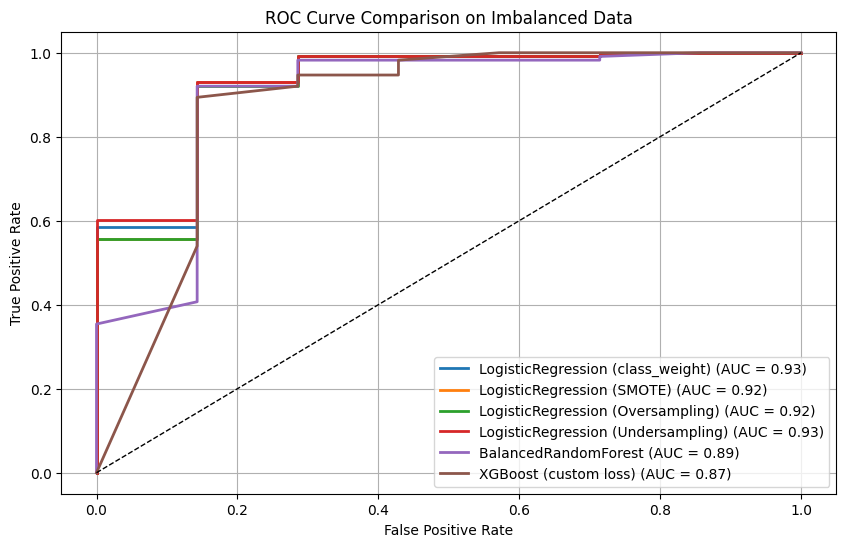

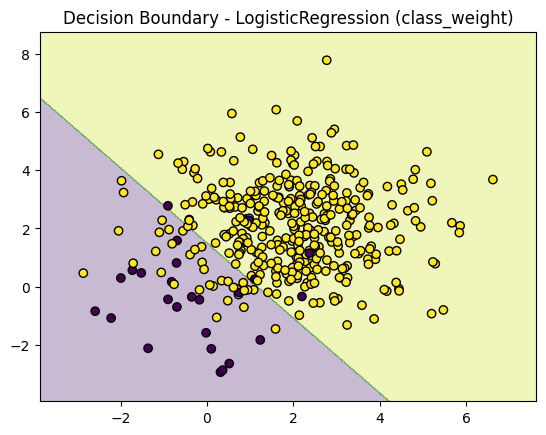

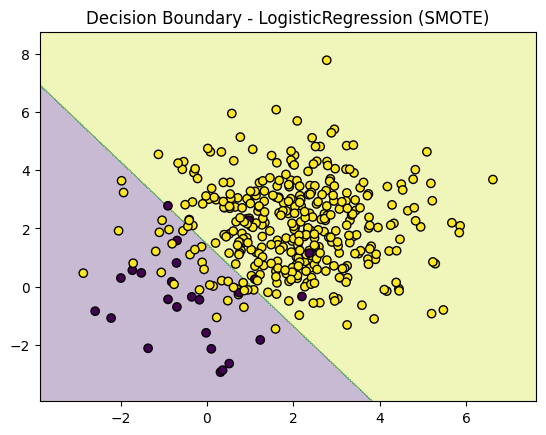

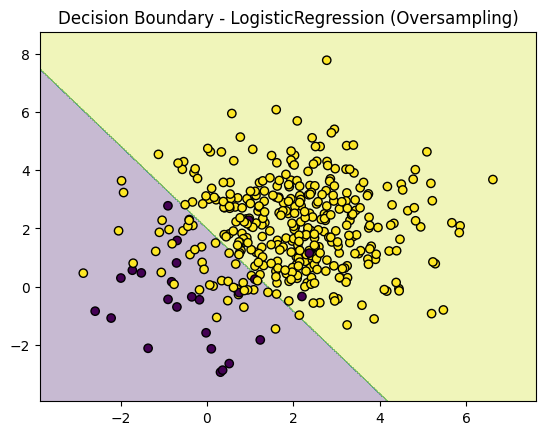

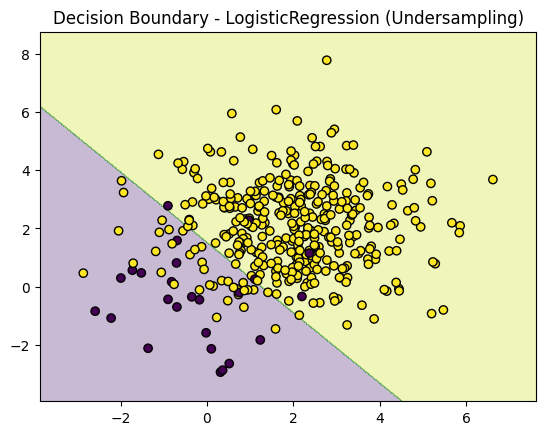

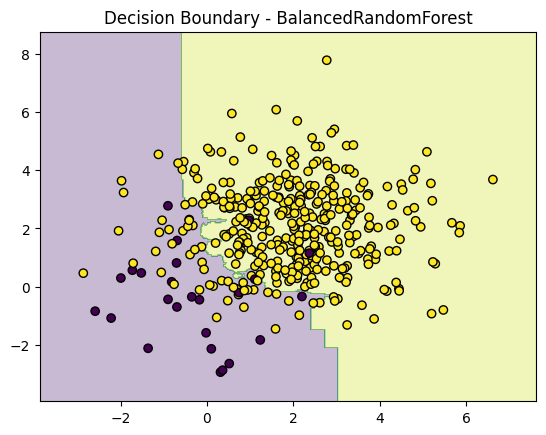

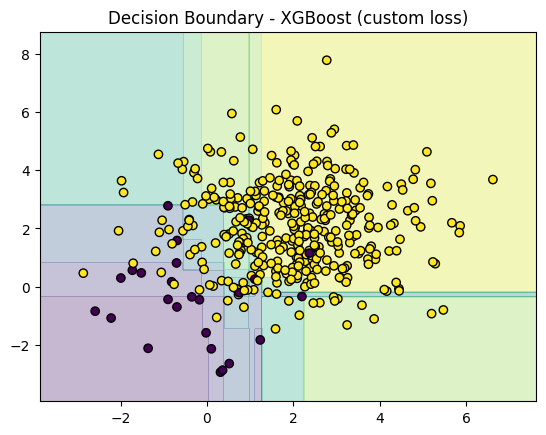

In [2]:
# Evaluate each model on the test set and plot ROC curves
plt.figure(figsize=(10, 6))
results = {}
for name, model in models.items():
    # For xgboost, use DMatrix for predictions
    if "XGBoost" in name:
        y_pred = (model.predict(dtest) > 0.5).astype(int)
        y_proba = model.predict(dtest)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    results[name] = roc_auc_score(y_test, y_proba)
    plot_roc_curve(y_test, y_proba, name)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison on Imbalanced Data")
plt.legend()
plt.grid()
plt.savefig("roc_curve_comparison.png")
plt.show()

# Plot decision boundaries for each model
for name, model in models.items():
    plot_decision_boundary(X, y, model, f"Decision Boundary - {name}")



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


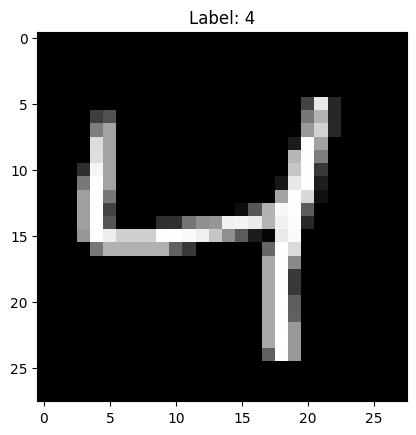

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,938 (409.91 KB)

 Trainable params: 104,938 (409.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8493 - loss: 0.5011 - val_accuracy: 0.9530 - val_loss: 0.1578
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9635 - loss: 0.1184 - val_accuracy: 0.9673 - val_loss: 0.1127
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9754 - loss: 0.0812 - val_accuracy: 0.9656 - val_loss: 0.1125
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9806 - loss: 0.0611 - val_accuracy: 0.9695 - val_loss: 0.0996
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9855 - loss: 0.0461 - val_accuracy: 0.9719 - val_loss: 0.0940
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9898 - loss: 0.0347 - val_accuracy: 0.9712 - val_loss: 0.1073
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9909 - loss: 0.0296 - val_accuracy: 0.9747 - val_loss: 0.0942
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9925 - loss: 0.0230 - 

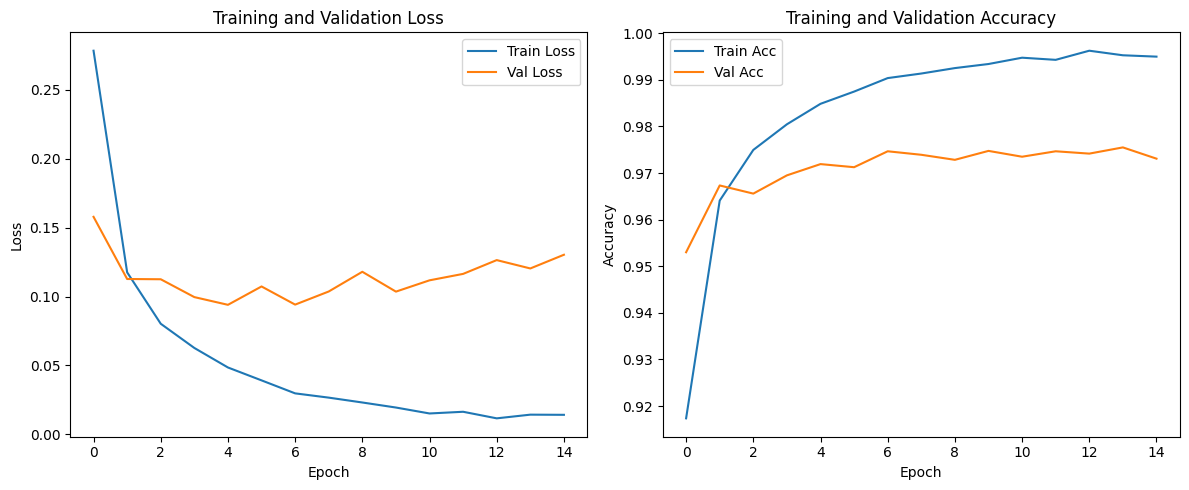

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


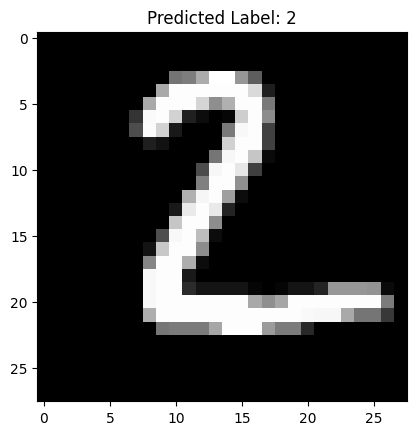

In [3]:
#######################
# Part 2: MNIST Evaluation with Keras
#######################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import accuracy_score

# Load MNIST dataset
(Xm_train, ym_train), (Xm_test, ym_test) = keras.datasets.mnist.load_data()

# Show a sample image and its label
plt.imshow(Xm_train[2], cmap='gray')
plt.title(f"Label: {ym_train[2]}")
plt.show()

# Normalize pixel values
Xm_train = Xm_train / 255.0
Xm_test = Xm_test / 255.0

# Build the model
mnist_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

mnist_model.summary()

# Compile the model
mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = mnist_model.fit(Xm_train, ym_train, epochs=15, validation_split=0.2, verbose=1)

# Evaluate on the test set
y_prob = mnist_model.predict(Xm_test)
y_pred = y_prob.argmax(axis=1)
acc = accuracy_score(ym_test, y_pred)
print("\nMNIST Model Accuracy:", acc)

# Plot training history: loss and accuracy over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()

plt.tight_layout()
plt.savefig('Training-Validation-Loss-Accuracy.png')
plt.show()

# Display a test sample along with predicted label
plt.imshow(Xm_test[1], cmap='gray')
predicted_label = mnist_model.predict(Xm_test[1].reshape(1, 28, 28)).argmax(axis=1)
plt.title(f"Predicted Label: {predicted_label[0]}")
plt.show()
